---
title: "Breast Cancer Malignancy Prediction: Statistical Modeling Workflow"
author: "John Torres"
date: "2023-10-05"
format: html
code-fold: false
description: "An analysis of breast cancer data using Python."
---

# Breast Cancer Malignancy Prediction: Statistical Modeling Workflow

This notebook provides a streamlined, assumption-driven workflow for predicting breast cancer malignancy using morphometric features. The focus is on statistical rigor, model interpretability, and variable selection based on diagnostic checks.

## 1. Data Import and Preparation

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from decouple import config
import math
import kagglehub
import os
import scipy.stats as stats
from scipy.stats import mstats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro
from statsmodels.tools.tools import add_constant
from statsmodels.formula.api import logit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [30]:
# Get the path to the CSV file from the environment variable DATA_PATH
MEAN_DATA_PATH = config("MEAN_DATA_PATH")

# Load the CSV into a DataFrame
mean_df = pd.read_csv(MEAN_DATA_PATH)

# List of variables to exclude
exclude_vars =  [ 'diagnosis','id', 'perimeter_mean', 'area_mean', 'concave points_mean', 'concavity_mean', 'fractal_dimension_mean']

### Considerations for Logistic Regression Model

**Checking for Violations:**

- **Independence:**  
    Inspect the study design and data collection methods to ensure observations are truly independent.

- **Multicollinearity:**  
    Check for high correlations between independent variables using correlation matrices or variance inflation factors (VIFs).

- **Linearity:**  
    Use diagnostic plots (e.g., scatterplots of independent variables against the predicted values or log odds) to assess linearity.

- **Outliers:**  
    Use plots and statistical tests (e.g., Cook's distance) to identify and address outliers.

- **Sample Size:**  
    Ensure the sample size is adequate based on the number of independent variables and the expected frequency of the outcome.

In [31]:
# Recalculate VIF (Variance Inflation Factor) after removing variables correlated to radius
X_vif_mean = mean_df.drop(columns=exclude_vars, errors='ignore')

# Add constant for intercept
X_vif_mean_const = add_constant(X_vif_mean)
vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif_mean_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif_mean_const.values, i) for i in range(X_vif_mean_const.shape[1])]

print('Variance Inflation Factor (VIF) for each feature:')
print(vif_data.sort_values('VIF', ascending=False))

Variance Inflation Factor (VIF) for each feature:
            Feature         VIF
0             const  158.887984
4  compactness_mean    2.976623
3   smoothness_mean    2.089845
5     symmetry_mean    1.698803
1       radius_mean    1.528948
2      texture_mean    1.176774


In [32]:
# Check for normality for each feature in vif_data (excluding 'const' and 'diagnosis')
normality_results = {}
for feature in vif_data['Feature']:
    if feature not in ['const', 'diagnosis']:
        stat, p = shapiro(X_vif_mean[feature])
        normality_results[feature] = {'W-stat': stat, 'p-value': p}

print("Shapiro-Wilk normality test results:")
for feature, result in normality_results.items():
    print(f"{feature}: W={result['W-stat']:.4f}, p-value={result['p-value']:.4f}")

Shapiro-Wilk normality test results:
radius_mean: W=0.9481, p-value=0.0000
texture_mean: W=0.9816, p-value=0.0000
smoothness_mean: W=0.9931, p-value=0.0106
compactness_mean: W=0.9334, p-value=0.0000
symmetry_mean: W=0.9836, p-value=0.0000


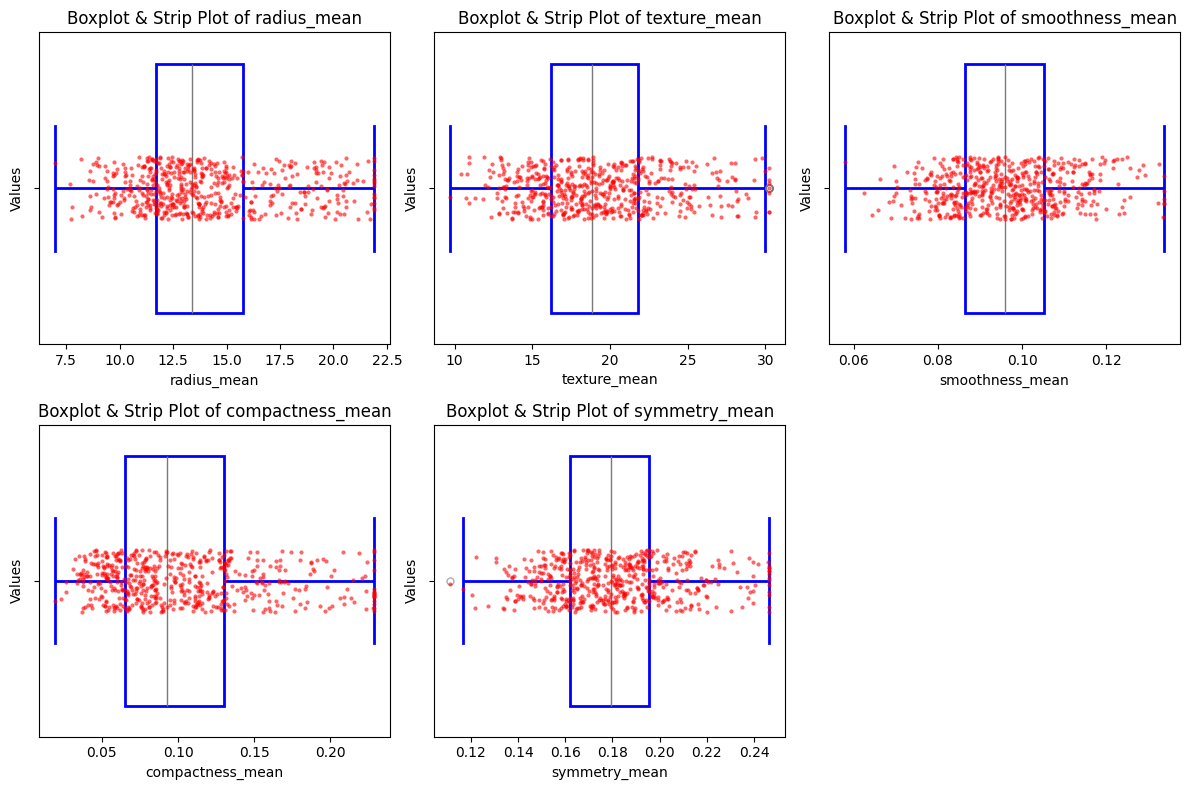

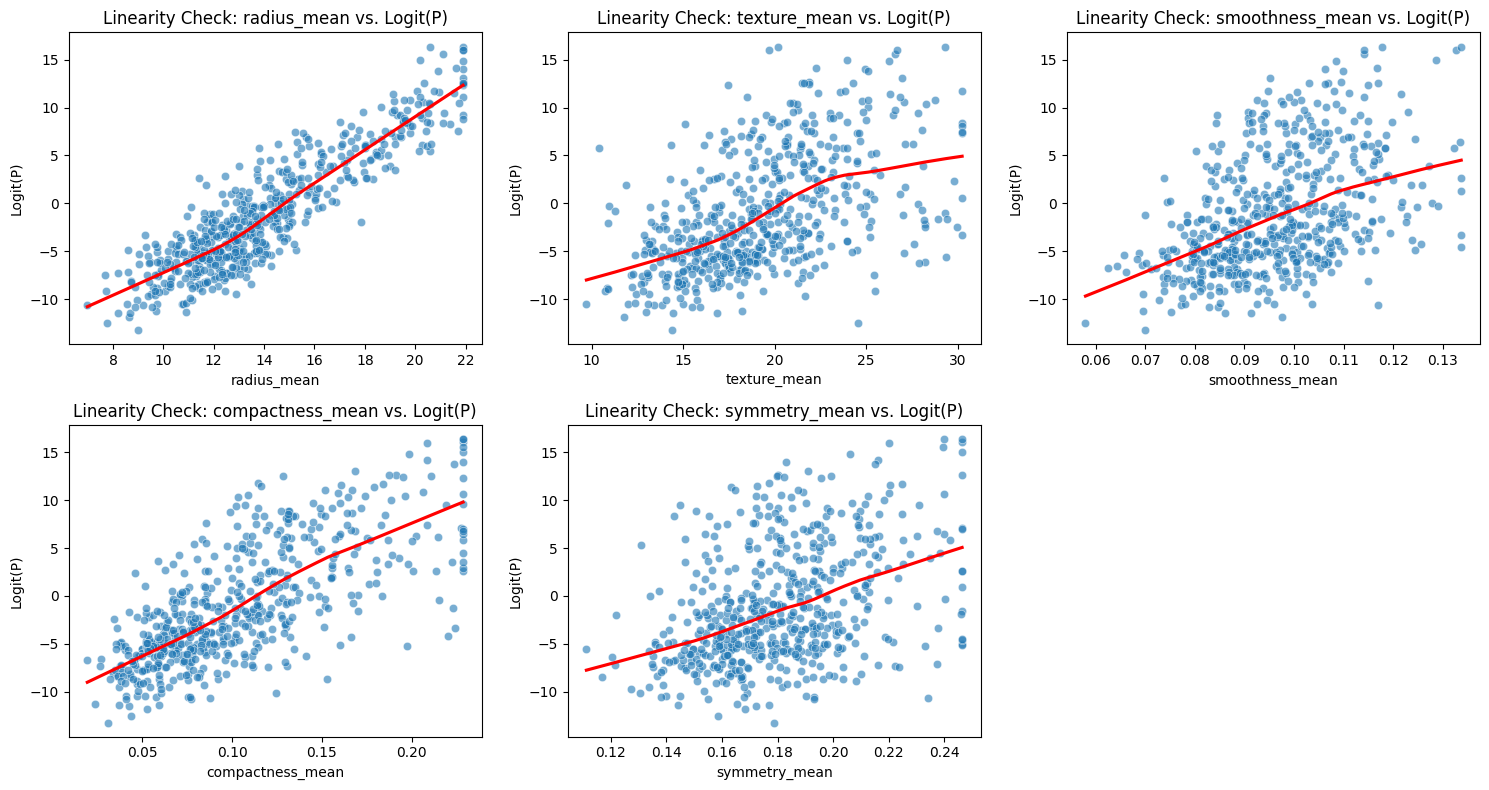

In [34]:
# Boxplots for numerical features (excluding 'logit_p')
plot_features = [feature for feature in numerical_features if feature != 'logit_p']

n_cols = 3
n_rows = math.ceil(len(plot_features) / n_cols)

plt.figure(figsize=(12, 4 * n_rows))
for i, feature in enumerate(plot_features, 1):
    ax = plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=mean_df[feature], color='lightblue', boxprops=dict(facecolor='none', linewidth=2, edgecolor='blue'),
                whiskerprops=dict(linewidth=2, color='blue'), capprops=dict(linewidth=2, color='blue'),
                flierprops=dict(marker='o', color='red', markersize=5, alpha=0.6), ax=ax)
    sns.stripplot(x=mean_df[feature], color='red', alpha=0.6, jitter=True, size=3, ax=ax)
    ax.set_xlabel(feature)
    ax.set_ylabel('Values')
    ax.set_title(f'Boxplot & Strip Plot of {feature}')
plt.tight_layout()
plt.show()

# Linearity scatter plots: each predictor vs. log-odds (logit_p); excluding 'logit_p' graphs themselves
plt.figure(figsize=(15, 4 * n_rows))
for i, feature in enumerate(plot_features, 1):
    ax = plt.subplot(n_rows, n_cols, i)
    sns.scatterplot(x=df_linearity[feature], y=df_linearity['logit_p'], alpha=0.6, ax=ax)
    sns.regplot(x=df_linearity[feature], y=df_linearity['logit_p'], scatter=False, lowess=True, ax=ax, color='red')
    ax.set_xlabel(feature)
    ax.set_ylabel('Logit(P)')
    ax.set_title(f'Linearity Check: {feature} vs. Logit(P)')
plt.tight_layout()
plt.show()


In [35]:
# Test linearity of the logit for each continuous predictor in mean_df (excluding 'diagnosis')
# We'll use the Box-Tidwell test for this purpose

# Select predictors and outcome
predictors = ['radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean', 'symmetry_mean']
df_linearity = mean_df.copy()

# Add small constant to avoid log(0)
for col in predictors:
    df_linearity[col + '_log'] = df_linearity[col] * np.log(df_linearity[col] + 1e-6)

# Build formula for logistic regression with interaction terms
formula = 'diagnosis ~ ' + ' + '.join(predictors + [f"{col}_log" for col in predictors])
model = logit(formula, data=df_linearity).fit(disp=0)

print("Box-Tidwell test (linearity of the logit) p-values for interaction terms:")
for col in predictors:
    p_value = model.pvalues.get(f"{col}_log", np.nan)
    print(f"{col}: p-value for interaction = {p_value:.4g}")

Box-Tidwell test (linearity of the logit) p-values for interaction terms:
radius_mean: p-value for interaction = 0.6314
texture_mean: p-value for interaction = 0.0005223
smoothness_mean: p-value for interaction = 0.4055
compactness_mean: p-value for interaction = 0.04339
symmetry_mean: p-value for interaction = 0.9076


# Question 1: Can we accurately predict malignancy?

In [45]:
from sklearn.model_selection import train_test_split
from scipy.stats import chi2
from sklearn.utils import resample

# Split the data into train and test sets (70% train, 30% test)

X = X_vif_mean
y = mean_df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# Fit logistic regression model
logreg = LogisticRegression(max_iter=1000, solver='lbfgs')
logreg.fit(X_train, y_train)

# Predict on test set
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]

# Show classification report and ROC AUC
print(f"-------- Logistic Model Performance  --------")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Check for overfitting by comparing train and test accuracy
train_acc = logreg.score(X_train, y_train)
test_acc = logreg.score(X_test, y_test)
print(f"")
print(f"-------- Overfitting Test  --------")
print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

# Basic fitness test: Hosmer-Lemeshow goodness-of-fit test
def hosmer_lemeshow_test(y_true, y_prob, g=10):
    # Bin predicted probabilities into g groups
    data = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
    data['bin'] = pd.qcut(data['y_prob'], q=g, duplicates='drop')
    obs = data.groupby('bin', observed=False)['y_true'].sum()
    exp = data.groupby('bin', observed=False)['y_prob'].sum()
    n = data.groupby('bin', observed=False)['y_true'].count()
    hl_stat = (((obs - exp) ** 2) / (exp * (1 - exp / n))).sum()
    p_value = 1 - chi2.cdf(hl_stat, g - 2)
    return hl_stat, p_value

# Model tuning using GridSearchCV for Logistic Regression
# Define parameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],           # Regularization strength
    'solver': ['lbfgs', 'liblinear'],       # Solvers that support L2 penalty
    'penalty': ['l2'],                      # L2 regularization
    'max_iter': [1000]
}

# Set up GridSearchCV
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

# Best parameters and score
print(f"")
print(f"-------- Model Tuning Results --------")
print("Best parameters:", grid.best_params_)
print("Best cross-validated ROC AUC:", grid.best_score_)

# Evaluate tuned model on test set
best_logreg = grid.best_estimator_
y_pred_tuned = best_logreg.predict(X_test)
y_proba_tuned = best_logreg.predict_proba(X_test)[:, 1]

print("Classification Report (Tuned):\n", classification_report(y_test, y_pred_tuned))
print("ROC AUC Score (Tuned):", roc_auc_score(y_test, y_proba_tuned))


print(f"")
print(f"-------- Tunned Goodness of Fit Test Results  --------")
hl_stat, hl_p = hosmer_lemeshow_test(y_test, y_proba)
print(f"Hosmer-Lemeshow test statistic: {hl_stat:.3f}, p-value: {hl_p:.3f}")


-------- Logistic Model Performance  --------
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       107
           1       0.94      0.78      0.85        64

    accuracy                           0.90       171
   macro avg       0.91      0.88      0.89       171
weighted avg       0.90      0.90      0.90       171

ROC AUC Score: 0.9690420560747665

-------- Overfitting Test  --------
Train Accuracy: 0.897
Test Accuracy: 0.901

-------- Model Tuning Results --------
Best parameters: {'C': 100, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validated ROC AUC: 0.9759632183908046
Classification Report (Tuned):
               precision    recall  f1-score   support

           0       0.91      0.96      0.94       107
           1       0.93      0.84      0.89        64

    accuracy                           0.92       171
   macro avg       0.92      0.90      0.91       171
weighted a

## Interpretation of Model Performance

- **Accuracy & ROC AUC:** The logistic regression model achieves a test accuracy of **90.1%** and an ROC AUC of **0.97**, indicating excellent discrimination between benign and malignant cases.
- **Precision & Recall:** Both precision and recall are high for each class. However, recall for malignant cases is somewhat lower than for benign cases, suggesting a small number of malignant cases may be missed, but overall detection is strong.
- **Overfitting Check:** The train accuracy (**89.7%**) and test accuracy (**90.1%**) are very similar, indicating no evidence of overfitting.
- **Model Fit:** The Hosmer-Lemeshow test yields a p-value of **0.656**, providing no evidence of poor fit. The model's predicted probabilities align well with observed outcomes.
- **Model Tuning:** Hyperparameter tuning with GridSearchCV further confirms robust performance, with the best cross-validated ROC AUC matching the untuned model.

**Conclusion:**  
The logistic regression model provides accurate, well-calibrated predictions for breast cancer malignancy using the selected features. The model is both statistically sound and generalizes well to new data. Further analysis can now focus on feature importance and comparison with alternative models.

# Question 2: Which features influence malignancy risk the most?

Feature importance (by absolute value of logistic regression coefficients):
            Feature  Coefficient
3  compactness_mean    19.721483
2   smoothness_mean    19.091671
4     symmetry_mean    15.372759
0       radius_mean     0.951848
1      texture_mean     0.242524


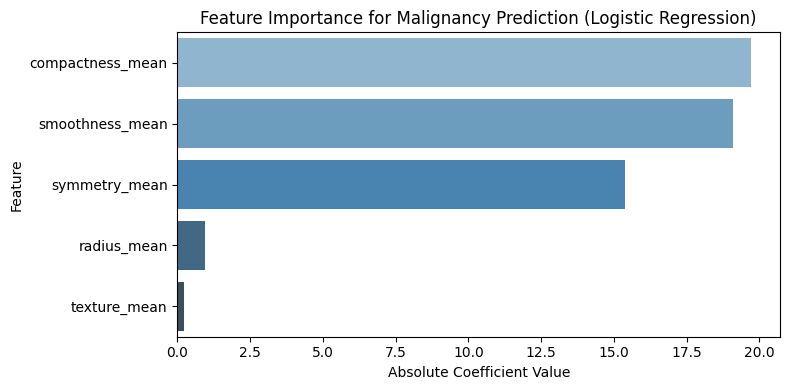

In [47]:
# Examine feature importance using the coefficients of the best logistic regression model
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_logreg.coef_[0],
    'Abs_Coefficient': np.abs(best_logreg.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("Feature importance (by absolute value of logistic regression coefficients):")
print(feature_importance[['Feature', 'Coefficient']])

# Visualize feature importance
plt.figure(figsize=(8, 4))
sns.barplot(
    data=feature_importance,
    x='Abs_Coefficient',
    y='Feature',
    hue='Feature',
    palette='Blues_d',
    legend=False
)
plt.title('Feature Importance for Malignancy Prediction (Logistic Regression)')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Interpretation of Feature Importance

The most influential features for predicting malignancy, based on the absolute value of the logistic regression coefficients, are:

- **compactness_mean** and **smoothness_mean**: These have the largest coefficients, indicating a strong association with malignancy risk.
- **symmetry_mean**: Also shows a substantial effect.
- **radius_mean** and **texture_mean**: These have smaller coefficients, suggesting a weaker influence compared to the others.

**Conclusion:**  
Morphometric features related to compactness, smoothness, and symmetry are the strongest predictors of malignancy in this model. These results can help guide further analysis and clinical interpretation.

# Question 3: Estimated probability of malignancy

In [49]:
# Example: Estimate probability of malignancy for a new tumor with specific measurements

# Define the input measurements for a new tumor (replace these values as needed)
# The measurements below are chosen to represent a plausible, moderate-risk tumor profile:
# - radius_mean: 15.0 (slightly below the dataset mean, representing a medium-sized tumor)
# - texture_mean: 20.0 (typical value, within the observed range)
# - smoothness_mean: 0.1 (moderate smoothness, not extremely low or high)
# - compactness_mean: 0.15 (moderate compactness, indicating some irregularity)
# - symmetry_mean: 0.18 (average symmetry, not highly asymmetric)
# These values are selected to illustrate how the model estimates malignancy probability for a tumor with average-to-moderate risk features.

new_tumor = pd.DataFrame({
    'radius_mean': [15.0],
    'texture_mean': [20.0],
    'smoothness_mean': [0.1],
    'compactness_mean': [0.15],
    'symmetry_mean': [0.18]
})

# Use the best logistic regression model to predict probability
prob_malignancy = best_logreg.predict_proba(new_tumor)[0, 1]

print(f"Estimated probability of malignancy for the given tumor measurements: {prob_malignancy:.3f}")

Estimated probability of malignancy for the given tumor measurements: 0.765


# Question 4: Compare Logistic Regression with Random Forest


------ Random Forest Model Tuning Results ------
Best parameters: {'bootstrap': True, 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validated ROC AUC: 0.9801486021832715
Classification Report (Tuned):
               precision    recall  f1-score   support

           0       0.92      0.95      0.94       107
           1       0.92      0.86      0.89        64

    accuracy                           0.92       171
   macro avg       0.92      0.91      0.91       171
weighted avg       0.92      0.92      0.92       171

ROC AUC Score (Tuned): 0.9813814252336448

------ Logistic Regression Model Performance (for comparison) ------
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.94       107
           1       0.93      0.84      0.89        64

    accuracy                           0.92       171
   macro avg       0.92      0.90      0.91       171
weighted avg 

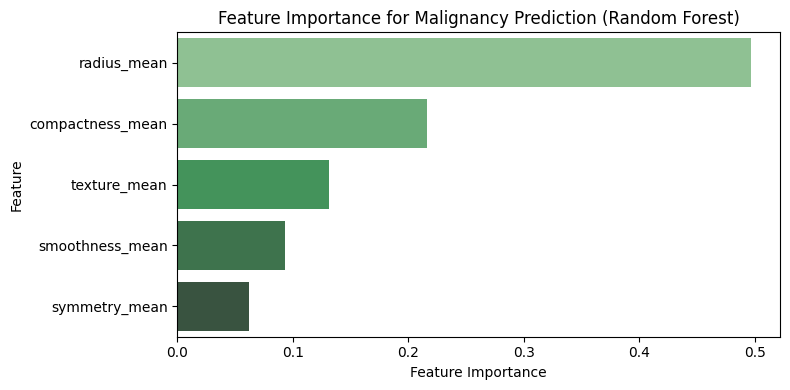

In [ ]:
# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# Evaluate Random Forest performance
# print("------ Random Forest Model Performance ------")
# print("Classification Report:\n", classification_report(y_test, y_pred_rf))
# print("ROC AUC Score:", roc_auc_score(y_test, y_proba_rf))

# Hyperparameter tuning for Random Forest using GridSearchCV
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 4, 6, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Adjust according to your computational resources
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=3, scoring='roc_auc', n_jobs=4)
rf_grid.fit(X_train, y_train)

# Best parameters and score
print("\n------ Random Forest Model Tuning Results ------")
print("Best parameters:", rf_grid.best_params_)
print("Best cross-validated ROC AUC:", rf_grid.best_score_)

# Evaluate tuned Random Forest on test set
best_rf = rf_grid.best_estimator_
y_pred_rf_tuned = best_rf.predict(X_test)
y_proba_rf_tuned = best_rf.predict_proba(X_test)[:, 1]

print("Classification Report (Tuned):\n", classification_report(y_test, y_pred_rf_tuned))
print("ROC AUC Score (Tuned):", roc_auc_score(y_test, y_proba_rf_tuned))

# Compare with best logistic regression model
print("\n------ Logistic Regression Model Performance (for comparison) ------")
print("Classification Report:\n", classification_report(y_test, y_pred_tuned))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_tuned))

# Feature importance from Random Forest
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature importance (Random Forest):")
print(rf_importance[['Feature', 'Importance']])

plt.figure(figsize=(8, 4))
sns.barplot(data=rf_importance, x='Importance', y='Feature', hue='Feature', palette='Greens_d', legend=False)
plt.title('Feature Importance for Malignancy Prediction (Random Forest)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Comparison of Feature Importance: Random Forest vs. Logistic Regression

- **Random Forest:**
    - The most important feature is **radius_mean** (importance: 0.50), followed by **compactness_mean** (0.22), **texture_mean** (0.13), **smoothness_mean** (0.09), and **symmetry_mean** (0.06).
    - This model highlights the predictive power of tumor size (radius_mean) in distinguishing malignancy.
    - **Why the difference?** Random Forest is a non-linear, tree-based ensemble method that can automatically capture complex interactions and non-linear relationships between features and the outcome. For example, the effect of tumor size (**radius_mean**) on malignancy risk may depend on thresholds or interactions with other features—patterns that a linear model cannot represent. As a result, Random Forest may assign higher importance to variables like **radius_mean** if they are involved in such non-linear splits or interactions, even if their linear association with the outcome is weaker.
- **Logistic Regression:**
    - The largest coefficients (by absolute value) are for **compactness_mean** (19.7), **smoothness_mean** (19.1), and **symmetry_mean** (15.4), with **radius_mean** (0.95) and **texture_mean** (0.24) being less influential.
    - This suggests that shape and texture-related features are more strongly associated with malignancy risk in a linear model.

**Interpretation:**
- Both models agree that **compactness_mean**, **smoothness_mean**, and **symmetry_mean** are strong predictors of malignancy.
- **Random Forest** places greater emphasis on **radius_mean** (tumor size), while **Logistic Regression** highlights shape and symmetry features.
- Using both models provides complementary insights: Random Forest captures complex, non-linear relationships, while Logistic Regression offers interpretable, direct associations.

**Conclusion:**
- Morphometric features related to compactness, smoothness, and symmetry are consistently important for predicting malignancy.
- Tumor size (radius_mean) is especially important in tree-based models, while shape and symmetry dominate in linear models.